In [ ]:
import numpy as np

In [ ]:
game = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ])
mask = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ])


p1_game = game[:,:6]
p2_game = game[:,6:]

p1_mask = mask[:,:6]
p2_mask = mask[:,6:]


p1_dice = np.random.randint(1, 7, 5)
p2_dice = np.random.randint(1, 7, 5)

print(p1_dice)

turn = 0
while turn < 3:
    # print(f"Turn {turn}")
    # print(f"Player 1: {p1_dice}")
    # print(f"Player 2: {p2_dice}")
    p1_dice = np.random.randint(1, 7, 5)
    p1_sum = np.sum(p1_dice)
    
    turn += 1


Implement abaka

Game is over


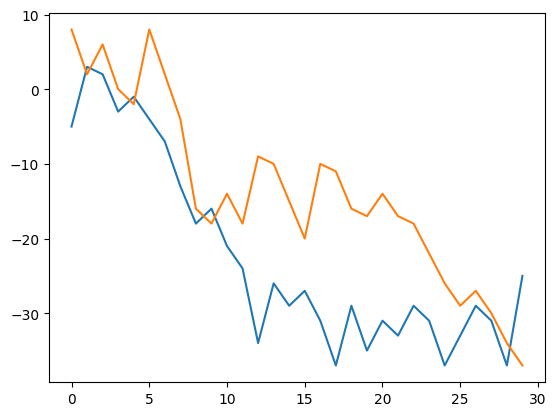

In [92]:
import numpy as np

# Game rules:
# - Two players compete against each other to score the most points.
# - The game has a table with different combinations of dice that can be scored
# - Each combination has 5 fields and one bonus field for each player to fill on his side of the board.
# - The bonus field is filled when all 5 fields are filled. The value of the bonus field is the maximum value of the 5 fields.
# - Only one player can score a bonus field in each row. Once a player scores a bonus field, the other player loses the opportunity to score it.
# - At the beggining of every turn, the player rolls 5 dice
# - He then can keep any number of dice and can make 2 throws with the other. He may keep all dice after the first roll if he wants.
# - Player must action a category to score

# The game gives the player a state and the player must return an action
# Game includes the following:
# - table_state
# - mask_state
# - dice_state
# - player_turn_state
# - throws_left_state
# - action_return_state
# - valid_actions_state

# The player must return an action
# - dice2keep action (2^5 = 32 possible actions)
# - cell2score action (6 possible actions)
# In total, the player has 45 possible actions

class Abaka:
    def __init__(self):
        self.table_state = np.zeros((6,12)).astype(int)
        self.mask_state = np.zeros((6,12)).astype(int)

        # # fill mask for unavailable bonus fields
        # self.mask[-1, -6] = 1
        # self.mask[-1, -1] = 1

        self.dice_state = np.random.randint(1, 7, 5).astype(int) # generate 5 random dice for the first player
        self.player_turn_state = np.array([0]).astype(int) # 0 if player 1, 1 if player 2
        self.throws_left_state = np.array([2]).astype(int) # Each player is give 2 throws at the beginning of their turn
        self.actions_return_state, self.actions_mask_state = self.get_actions_return_and_mask() # generate the possible actions for the first player

    def is_over(self):
        return np.sum(self.mask_state) == 72
    
    def get_state(self):
        state = np.concatenate([
        self.table_state.flatten(),
        self.mask_state.flatten(),
        self.dice_state,
        self.player_turn_state,
        self.throws_left_state,
        self.actions_return_state,
        self.actions_mask_state
        ])
        return state

    def print_state(self):
        def print_aligned_state(table_state):
            print("Table state:")
            print("-----------------------------------------------")
            for i, row in enumerate(table_state):
                formatted_row = "|{:<}|  {:>2} {:>2} {:>2} {:>2} {:>2} |{:2}|    {:>2} {:>2} {:>2} {:>2} {:>2} |{:>2}|".format(
                    i + 1, *row)
                print(formatted_row)
            print("-----------------------------------------------")
        # print aligned table state
        print_aligned_state(self.table_state)
        # print player scores
        print(f"Player 1 score: {self.get_player_score(0)}")
        print(f"Player 2 score: {self.get_player_score(1)}")
        print("\n")

        if self.player_turn_state[0] == 0:
            print("Player 1 turn")
        else:
            print("Player 2 turn")
        print("Dice state:")
        print(self.dice_state)
        print(f"Throws left : {self.throws_left_state[0]}")
        print("\n")

    def match_combinations(self):
        def match_n_of_a_kind(dice_state, n=2):
            counts = np.bincount(dice_state, minlength=7)[1:]
            counts = counts.astype(int)
            actions_mask = (counts >= n).astype(int)
            # actions_return = actions_mask * counts * np.arange(1, 7)
            actions_return = np.where(actions_mask == 1, counts * np.arange(1, 7), np.arange(-1, -7, -1))
            return actions_return, np.ones_like(actions_mask)
        # match pairs
        actions_return, actions_mask = match_n_of_a_kind(self.dice_state)

        # check if cells are available
        ix = self.player_turn_state[0]*7 # select player
        available_cells_mask = np.sum(self.mask_state[:,ix:ix+5], axis=1) < 5
        
        actions_return = actions_return * available_cells_mask
        actions_mask = actions_mask * available_cells_mask

        return actions_return, actions_mask
    
    def get_actions_return_and_mask(self):
        # return array of returns and valid actions
        if self.throws_left_state > 0:
            # dice2keep_return = np.zeros(32)
            dice2keep_mask = np.ones(32).astype(int) # if throws left, any number of dice can be kept
        else:
            dice2keep_mask = np.zeros(32).astype(int) # if no throws left, no dice can be kept

        # evaluate dice state to get valid actions and their returns
        actions_return, cell2score_actions_mask = self.match_combinations()
        
        # concatenate the two masks
        actions_mask = np.concatenate((dice2keep_mask, cell2score_actions_mask))
        return actions_return, actions_mask
        

    def keep_and_roll(self, action: int):
        def keep_and_roll(roll, keep):
            new_roll = np.random.randint(1, 7, 5)
            return np.where(keep == 1, roll, new_roll)
        keep = [int(i) for i in list(np.binary_repr(action, width=5))]
        self.dice_state = keep_and_roll(self.dice_state, keep)

    def get_action_reward(self, action: int):
        return game.actions_return_state[action]

    def get_player_score(self, player_id: int):
        ix = player_id*6
        return np.sum(self.table_state[:,ix:ix+6])

    def process_action(self, action: int):
        if self.actions_mask_state[action] == 0:
            raise ValueError("Invalid action")
        
        if action < 32:
            self.keep_and_roll(action)
            self.throws_left_state -= 1

            score = self.get_player_score(self.player_turn_state[0])

        else:
            action -= 32 # offset action
            reward = self.get_action_reward(action) # get reward for the action
            iy = action
            player_ix = self.player_turn_state[0]*6
            n_filled = np.sum(self.mask_state[iy,player_ix:player_ix+5])
            ix = player_ix + n_filled
            self.table_state[iy,ix] = reward
            self.mask_state[iy,ix] = 1

            # process bonus field
            if ix == 4 or ix == 10:
                # check if the bonus field is available
                if self.mask_state[iy,ix+1] == 0:
                    max_reward = np.max(self.table_state[iy,ix-4:ix+1])
                    self.table_state[iy,ix+1] = max_reward
                    # block rewards for both players
                    self.mask_state[iy,5] = 1
                    self.mask_state[iy,-1] = 1

            # record the score before changing the player
            score = self.get_player_score(self.player_turn_state[0])
            
            self.player_turn_state = (self.player_turn_state + 1) % 2
            self.throws_left_state = np.array([2]).astype(int)
            
        # update the actions
        self.actions_return_state, self.actions_mask_state = self.get_actions_return_and_mask()
        
        return score

    # process the action and return the new state
    def step(self, action: int):
        # process the action
        score = self.process_action(action)
        return score


game = Abaka()

N_steps = 200

players_scores = [[], []]

for i in range(N_steps):
    if game.is_over():
        print("Game is over")
        break
    # game.print_state()
    state = game.get_state()
    available_actions = state[-38:]
    action = np.random.choice(np.where(available_actions)[0],1)
    action = action[0]
    player_idx = game.player_turn_state[0]
    score = game.step(action)
    new_player_idx = game.player_turn_state[0]
    if player_idx != new_player_idx:
        players_scores[player_idx].append(score)

# game.print_state()

from matplotlib import pyplot as plt
plt.plot(players_scores[0], label="Player 1")
plt.plot(players_scores[1], label="Player 2")

In [22]:
game.print_state()

print(game.mask_state)

Table state:
-----------------------------------------------
|1|  -1 -1 -1  2 -1 | 2|    -1 -1 -1 -1  0 | 0|
|2|  -2 -2 -2  4 -2 | 4|     4 -2 -2  6 -2 | 0|
|3|  -3 -3 12 -3 -3 | 0|    -3 -3 -3 -3 -3 |-3|
|4|  -4 -4 -4 -4  8 | 0|    -4 -4 -4 -4 -4 |-4|
|5|  -5 -5 -5 -5 -5 | 0|    -5 -5 -5 -5 -5 |-5|
|6|  -6 18 -6 12 -6 |18|    -6 -6 -6 -6 -6 | 0|
-----------------------------------------------
Dice state:
[3 3 1 4 3]
Player turn : 1
Throws left : 2


[[1 1 1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]]


In [19]:
np.sum(game.mask_state)

72

In [254]:
game.table_state.shape

(6, 12)

In [ ]:
game.print_state()
# game.mask_state
game.get_actions_return_and_mask()
available_cells_mask = np.sum(game.mask_state[:,game.player_turn_state[0]*7:(game.player_turn_state[0]+1)*7]) < 5
print(available_cells_mask)

Table state:
----------------------------
1: 0 0 0 0 0 |0| 3 -1 0 0 |0|
2: -2 0 0 0 0 |0| 0 0 0 0 |0|
3: 0 0 0 0 0 |0| 0 0 0 0 |0|
4: -4 0 0 0 0 |0| -4 0 0 0 |0|
5: -5 -5 0 0 0 |0| -5 0 0 0 |0|
6: -6 0 0 0 0 |0| 0 0 0 0 |0|
----------------------------
Dice state:
[1 4 3 2 5]
Player turn : 0
Throws left : 0


False


In [227]:
print(game.mask_state[:,game.player_turn_state[0]*7:(game.player_turn_state[0]+1)*7])
np.sum(game.mask_state[:,game.player_turn_state[0]*7:(game.player_turn_state[0]+1)*7], axis=1) < 5

[[0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]]


array([ True,  True,  True,  True,  True,  True])

In [184]:
available_actions, game.dice_state

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([6, 1, 5, 3, 2]))

In [131]:
game.player_turn_state[0]*6,game.player_turn_state[0]*6*2

(0, 0)

In [133]:
game.mask_state[action,game.player_turn_state[0]*6:(game.player_turn_state[0]+1)*6]

array([1, 1, 1, 1, 1, 1])

In [176]:
np.sum(game.mask_state[action,game.player_turn_state[0]*6:game.player_turn_state[0]*6*2]).astype(int) 

IndexError: index 34 is out of bounds for axis 0 with size 6

In [119]:
game.player_turn_state[0] * 6 + np.sum(game.mask_state[action,game.player_turn_state[0]*6:game.player_turn_state[0]*6*2]).astype(int) 

/var/folders/9m/w_5nn17s0kj2fgjdbvdhg38m0000gn/T/ipykernel_6886/2607578476.py:1: DeprecationWarning: Out of bound index found. This was previously ignored when the indexing result contained no elements. In the future the index error will be raised. This error occurs either due to an empty slice, or if an array has zero elements even before indexing.
(Use `warnings.simplefilter('error')` to turn this DeprecationWarning into an error and get more details on the invalid index.)
  game.player_turn_state[0] * 6 + np.sum(game.mask_state[action,game.player_turn_state[0]*6:game.player_turn_state[0]*6*2]).astype(int)


0

In [117]:
game.player_turn_state[0] * 6 + np.sum(game.mask_state[action,game.player_turn_state[0]*6:game.player_turn_state[0]*6*2]).astype(int) 

/var/folders/9m/w_5nn17s0kj2fgjdbvdhg38m0000gn/T/ipykernel_6886/2607578476.py:1: DeprecationWarning: Out of bound index found. This was previously ignored when the indexing result contained no elements. In the future the index error will be raised. This error occurs either due to an empty slice, or if an array has zero elements even before indexing.
(Use `warnings.simplefilter('error')` to turn this DeprecationWarning into an error and get more details on the invalid index.)
  game.player_turn_state[0] * 6 + np.sum(game.mask_state[action,game.player_turn_state[0]*6:game.player_turn_state[0]*6*2]).astype(int)


0

In [ ]:
s = r"""
|   |
|___|
"""
print(s)


 ___
|   |
|___|



In [ ]:
# (game.player_turn_state[0])
np.sum(game.table_state[:,game.player_turn_state[0]*6:game.player_turn_state[0]*6*2])

/var/folders/9m/w_5nn17s0kj2fgjdbvdhg38m0000gn/T/ipykernel_94213/1373492804.py:2: DeprecationWarning: Out of bound index found. This was previously ignored when the indexing result contained no elements. In the future the index error will be raised. This error occurs either due to an empty slice, or if an array has zero elements even before indexing.
(Use `warnings.simplefilter('error')` to turn this DeprecationWarning into an error and get more details on the invalid index.)
  np.sum(game.table_state[action,game.player_turn_state[0]*6:game.player_turn_state[0]*6*2])


0

In [366]:
# convert to binary
game.actions_mask_state.shape

(38,)